In [1]:
%pwd

u'/home/ubuntu/kaggle/nature'

In [8]:
import os, sys
current_dir = os.getcwd()

LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir + '/data'

In [9]:
path = DATA_HOME_DIR + '/' + 'sample/'
train_path= path + '/train/'
valid_path= path + '/valid/'

In [7]:
# from theano.sandbox import cuda
# cuda.use('gpu1')

In [10]:
import glob
from shutil import copyfile

from utils import *
from utils import Vgg16

%matplotlib inline

## Contents <a id='top'></a>
1. <a href='#organization'>Organizing data</a>
2. <a href='#training'>Model Training</a>

assumes all files are unzipped.

## Organizing data between training, test, and validation sets <a id='organization'><a>
<a href='#top'>back to top...</a>

Make Directory for sample data

In [92]:
%cd data/

[Errno 2] No such file or directory: 'data/'
/home/ubuntu/kaggle/nature/data


In [68]:
%rm -r sample/

In [71]:
%mkdir sample
%mkdir sample/train
%mkdir sample/valid
%mkdir sample/test

mkdir: cannot create directory ‘sample’: File exists
mkdir: cannot create directory ‘sample/train’: File exists
mkdir: cannot create directory ‘sample/valid’: File exists
mkdir: cannot create directory ‘sample/test’: File exists
mkdir: cannot create directory ‘valid’: File exists


In [94]:
%rm -r valid/
%rm -r train/

In [95]:
%mkdir valid
%mkdir train

mkdir: cannot create directory ‘train’: File exists


Make subdirectories for each class

In [193]:
for c in glob.glob(path + 'train/*'):
    d = c.split('/')[-1]
    os.mkdir('sample/train/' + d)
    os.mkdir('sample/valid/' + d)
#     os.mkdir('valid/' + d)

subdirectors for validation set.

In [96]:
for c in glob.glob(path + 'train/*'):
    d = c.split('/')[-1]
#     os.mkdir('sample/train/' + d)
#     os.mkdir('sample/valid/' + d)
    os.mkdir('valid/' + d)

In [97]:
%ls sample/valid/

In [195]:
%cd $DATA_HOME_DIR

/home/ubuntu/kaggle/nature/data


In [74]:
import glob

In [98]:
# these are the files given from kaggle.
g = glob.glob(path + 'train/*/*.jpg')
shuf = np.random.permutation(g)

In [99]:
g[:2]

['/home/ubuntu/kaggle/nature/data/train/YFT/img_01747.jpg',
 '/home/ubuntu/kaggle/nature/data/train/YFT/img_02918.jpg']

Make sample validation

In [91]:
n_sample_train = 1400
n_sample_validation = 800
n_validation = 755

In [197]:
for i in range(n_sample_train): 
    copyfile(shuf[i], path + 'sample/train/' + shuf[i].replace(path + 'train/', ''))

Make validation sample

In [198]:
for i in range(n_sample_validation): 
    j = i + n_sample_train
    copyfile(shuf[j], path+'sample/valid/' + shuf[j].replace(path + 'train/', ''))

Make full validation sample.

In [101]:
shuf = np.random.permutation(g)
for i in range(n_validation): 
    os.rename(shuf[i], path + 'valid/' + shuf[i].replace(path + 'train/', ''))

In [199]:
%ls $DATA_HOME_DIR

results/  sample_submission_stg1.csv.zip  test_stg1.zip  train.zip
sample/   test/                           train/         valid/


In [49]:
%mkdir test

In [51]:
%mkdir test/unknown

In [50]:
%mkdir results

In [58]:
%mv test_stg1/* test

In [59]:
%cd test/
%mv test_stg1/*.jpg unknown/

/home/ubuntu/kaggle/nature/data/test


In [62]:
%rm -r test_stg1

In [64]:
%cd $LESSON_HOME_DIR

/home/ubuntu/kaggle/nature


In [75]:
%mkdir data/sample/test

## Let's train the model <a id="training"></a>
<a href='#top'>back to top...</a>

In [83]:
path = DATA_HOME_DIR + '/' #'sample/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path=DATA_HOME_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

In [84]:
batch_size=64
no_of_epochs=3

In [242]:
batches = get_batches(path + 'train', batch_size=batch_size)
val_batches = get_batches(path + 'valid', batch_size=batch_size, shuffle=False)

Found 3022 images belonging to 8 classes.
Found 755 images belonging to 8 classes.


In [167]:
(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames,
    test_filename) = get_classes(path)

Found 3022 images belonging to 8 classes.
Found 755 images belonging to 8 classes.
Found 1000 images belonging to 1 classes.


### L2 regularization

In [21]:
model = Sequential([
        BatchNormalization(axis=1, input_shape=(3,224,224)),
        Flatten(),
        Dense(8, activation='softmax', W_regularizer=l2(0.01))
    ])

model.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(batches, batches.nb_sample, nb_epoch=2, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)

Epoch 1/2
1400/1400 [==============================] - 58s - loss: 2.0859 - acc: 0.5664 - val_loss: 3.4169 - val_acc: 0.6275
Epoch 2/2
1400/1400 [==============================] - 38s - loss: 0.9191 - acc: 0.7907 - val_loss: 1.7865 - val_acc: 0.6975


In [214]:
model.optimizer.lr=0.001
model.fit_generator(batches, batches.nb_sample, nb_epoch=4, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)

Epoch 1/4
1400/1400 [==============================] - 52s - loss: 0.2693 - acc: 0.9721 - val_loss: 0.6370 - val_acc: 0.8838
Epoch 2/4
1400/1400 [==============================] - 38s - loss: 0.2757 - acc: 0.9821 - val_loss: 0.7139 - val_acc: 0.8725
Epoch 3/4
1400/1400 [==============================] - 38s - loss: 0.2355 - acc: 0.9886 - val_loss: 0.6802 - val_acc: 0.8875
Epoch 4/4
1400/1400 [==============================] - 38s - loss: 0.2149 - acc: 0.9957 - val_loss: 0.6045 - val_acc: 0.9050


### Single hidden layer

In [133]:
model = Sequential([
        BatchNormalization(axis=1, input_shape=(3,224,224)),
        Flatten(),
        Dense(100, activation='relu'),
        BatchNormalization(),
        Dense(8, activation='softmax', W_regularizer=l2(0.01))
    ])

model.compile(Adam(lr=10e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(batches, batches.nb_sample, nb_epoch=2, validation_data=val_batches, 
                 nb_val_samples=val_batches.nb_sample)

Epoch 1/2
3022/3022 [==============================] - 91s - loss: 1.5103 - acc: 0.6456 - val_loss: 2.7422 - val_acc: 0.5152
Epoch 2/2
3022/3022 [==============================] - 77s - loss: 0.8011 - acc: 0.8458 - val_loss: 0.8552 - val_acc: 0.7894


In [135]:
model.optimizer.lr=0.001
for epoch in range(7):
    latest_weights_filename = results_path + 'single_layer%d.h5' % epoch
    print latest_weights_filename

    model.fit_generator(batches, batches.nb_sample, nb_epoch=1, validation_data=val_batches, 
                        nb_val_samples=val_batches.nb_sample)
    
    model.save_weights(latest_weights_filename)

/home/ubuntu/kaggle/nature/data/results/single_layer0.h5
Epoch 1/1
3022/3022 [==============================] - 92s - loss: 0.3604 - acc: 0.9646 - val_loss: 0.5055 - val_acc: 0.9152
/home/ubuntu/kaggle/nature/data/results/single_layer1.h5
Epoch 1/1
3022/3022 [==============================] - 92s - loss: 0.3289 - acc: 0.9772 - val_loss: 0.5072 - val_acc: 0.9272
/home/ubuntu/kaggle/nature/data/results/single_layer2.h5
Epoch 1/1
3022/3022 [==============================] - 92s - loss: 0.2713 - acc: 0.9854 - val_loss: 0.4342 - val_acc: 0.9404
/home/ubuntu/kaggle/nature/data/results/single_layer3.h5
Epoch 1/1
3022/3022 [==============================] - 92s - loss: 0.2236 - acc: 0.9937 - val_loss: 0.4360 - val_acc: 0.9404
/home/ubuntu/kaggle/nature/data/results/single_layer4.h5
Epoch 1/1
3022/3022 [==============================] - 93s - loss: 0.2248 - acc: 0.9931 - val_loss: 0.5055 - val_acc: 0.9351
/home/ubuntu/kaggle/nature/data/results/single_layer5.h5
Epoch 1/1
3022/3022 [============

In [301]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_18 (BatchNorm (None, 3, 224, 224)   12          batchnormalization_input_11[0][0]
____________________________________________________________________________________________________
flatten_13 (Flatten)             (None, 150528)        0           batchnormalization_18[0][0]      
____________________________________________________________________________________________________
dense_25 (Dense)                 (None, 100)           15052900    flatten_13[0][0]                 
____________________________________________________________________________________________________
batchnormalization_19 (BatchNorm (None, 100)           400         dense_25[0][0]                   
___________________________________________________________________________________________

# Load model weights

In [300]:
model_reloaded = Sequential([
        BatchNormalization(axis=1, input_shape=(3,224,224)),
        Flatten(),
        Dense(100, activation='relu'),
        BatchNormalization(),
        Dense(8, activation='softmax', W_regularizer=l2(0.01))
    ])

model_reloaded.load_weights('/home/ubuntu/kaggle/nature/data/results/single_layer6.h5')

In [ ]:
test_batches = get_batches(path + 'test', batch_size=batch_size, shuffle=True)

In [295]:
preds = model_reloaded.predict_generator(test_batches, test_batches.nb_sample)

save_array(results_path+'predictions.dat', preds)

In [169]:
save_array(results_path+'filenames.dat', [f.replace('unknown/', '') for f in test_filename])

In [325]:
[k for k in batches.class_indices.items()]

[('SHARK', 6),
 ('DOL', 2),
 ('NoF', 4),
 ('LAG', 3),
 ('ALB', 0),
 ('YFT', 7),
 ('OTHER', 5),
 ('BET', 1)]

In [328]:
target_lookup = {v: k for k, v in batches.class_indices.iteritems()}

In [373]:
df = pd.DataFrame(preds.clip(min=0.05, max=0.95))

In [374]:
df.columns = [target_lookup.get(c) for c in df.columns]

In [375]:
files_series = pd.DataFrame([f.replace('unknown/', '') for f in test_filename])

In [386]:
files_series.columns = ['image']

In [387]:
files_series.tail()

,image
995,img_00102.jpg
996,img_02648.jpg
997,img_04705.jpg
998,img_01984.jpg
999,img_01647.jpg


In [388]:
df.tail()

,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
995,0.050000,0.050000,0.050000,0.050000,0.05,0.763988,0.130502,0.05
996,0.601947,0.267297,0.050000,0.050000,0.05,0.050000,0.050000,0.05
997,0.277135,0.174624,0.052725,0.108798,0.05,0.314894,0.050000,0.05
998,0.950000,0.050000,0.050000,0.050000,0.05,0.050000,0.050000,0.05
999,0.950000,0.050000,0.050000,0.050000,0.05,0.050000,0.050000,0.05


In [389]:
files_series.join(df).to_csv(results_path + 'submission.csv', index=False)

In [390]:
FileLink(results_path + 'submission.csv')

/home/ubuntu/kaggle/nature/data/results/submission.csv

# Looking at Images

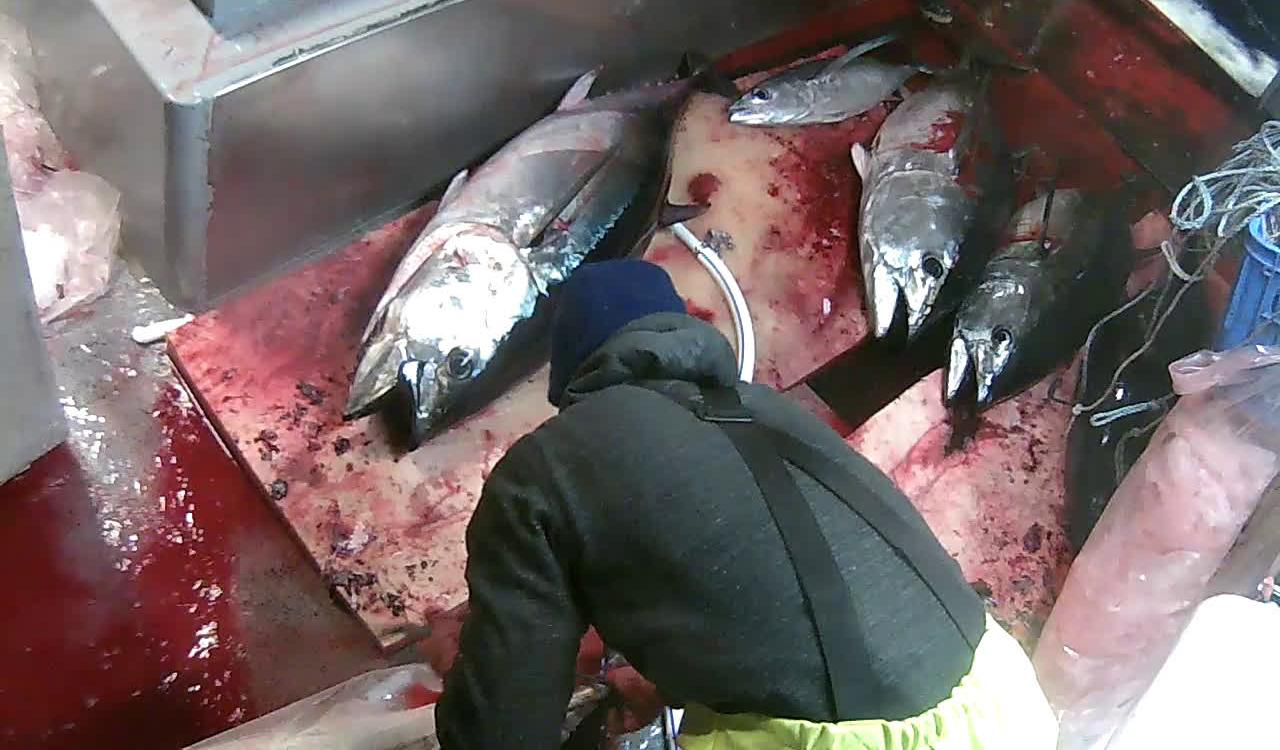

In [173]:
#You can verify the column ordering by viewing some images
from PIL import Image
Image.open(test_path + test_filename[2])

In [225]:
val_preds = model.predict_generator(val_batches, val_batches.nb_sample)

In [243]:
filenames = val_batches.filenames
expected_labels = val_batches.classes 

In [210]:
len(expected_labels)

755

In [202]:
batches.class_indices

{'ALB': 0,
 'BET': 1,
 'DOL': 2,
 'LAG': 3,
 'NoF': 4,
 'OTHER': 5,
 'SHARK': 6,
 'YFT': 7}

In [244]:
expected_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,


In [229]:
val_preds[2].argmax()

2

In [240]:
val_preds[2].argmax()

2

In [246]:
np.stack([np.array([row.argmax() for row in val_preds]),
         expected_labels])

array([[0, 5, 2, ..., 0, 6, 0],
       [0, 0, 0, ..., 7, 7, 7]])

In [249]:
[row[row.argmax()] for row in val_preds]

[0.98324341,
 0.9088611,
 0.96542692,
 0.96589649,
 0.93484217,
 0.96943128,
 0.95485085,
 0.95398062,
 0.98269224,
 0.9868117,
 0.98993623,
 0.97712213,
 0.98342496,
 0.99287331,
 0.93186325,
 0.71668589,
 0.9431504,
 0.98440278,
 0.98013109,
 0.97434223,
 0.96547383,
 0.98583382,
 0.98345011,
 0.96248585,
 0.97998363,
 0.96834475,
 0.47167146,
 0.97138083,
 0.97476608,
 0.87601238,
 0.98772007,
 0.97100723,
 0.94538265,
 0.98703593,
 0.96652859,
 0.97604781,
 0.95650816,
 0.97449374,
 0.98259211,
 0.97124106,
 0.96623355,
 0.99258739,
 0.95107412,
 0.85386997,
 0.98322737,
 0.80350935,
 0.99201947,
 0.98897153,
 0.95899683,
 0.97728515,
 0.94071347,
 0.83284938,
 0.96501899,
 0.99648029,
 0.9811523,
 0.99309123,
 0.95184606,
 0.98189354,
 0.82909691,
 0.68270797,
 0.94426197,
 0.98294914,
 0.96675628,
 0.85185289,
 0.96980047,
 0.9288376,
 0.77621412,
 0.97871929,
 0.74489313,
 0.85273498,
 0.94778264,
 0.94678235,
 0.40257278,
 0.92915457,
 0.97777361,
 0.91755849,
 0.96195453,
 0.9

In [276]:
our_predictions = np.array([row[row.argmax()] for row in val_preds])
our_labels = np.array([row.argmax() for row in val_preds])

In [277]:
np.where(our_labels==expected_labels)[0]

array([  0,   4,   5,   8,  10,  12,  13,  17,  18,  20,  21,  23,  24,  28,  29,  33,  41,  47,
        48,  56,  59,  61,  62,  63,  65,  66,  68,  69,  72,  73,  76,  82,  83,  85,  86,  88,
        90,  92,  93,  94,  96,  97,  98, 101, 104, 108, 113, 114, 115, 116, 118, 120, 123, 124,
       125, 126, 127, 128, 130, 131, 134, 135, 139, 143, 145, 146, 147, 148, 150, 151, 153, 154,
       156, 163, 164, 166, 167, 169, 170, 173, 177, 178, 184, 190, 194, 195, 196, 199, 200, 203,
       207, 208, 209, 210, 213, 214, 218, 220, 222, 225, 226, 228, 232, 234, 236, 237, 242, 243,
       248, 249, 250, 251, 252, 253, 256, 258, 267, 269, 272, 273, 274, 275, 276, 277, 282, 288,
       292, 293, 294, 295, 297, 298, 300, 305, 306, 310, 313, 316, 318, 319, 320, 321, 326, 331,
       333, 334, 340, 406, 416, 421, 422, 437, 439, 448, 454, 455, 460, 464, 466, 476, 480, 486,
       490, 504, 511, 516, 555, 563, 571, 608, 615, 617, 623, 624, 635, 642, 643, 644, 651, 657,
       661, 662, 665, 667, 670

In [262]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

Found 207 correct labels


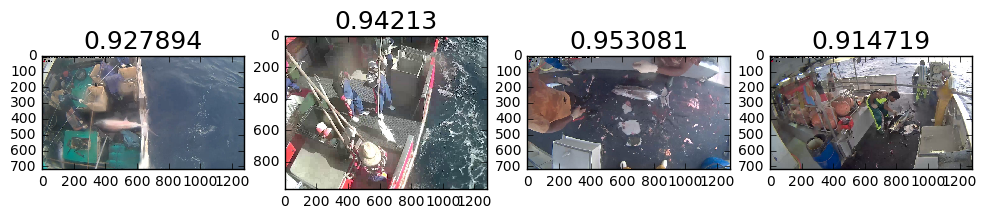

In [278]:
correct = np.where(our_labels==expected_labels)[0]
print "Found %d correct labels" % len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 548 incorrect labels


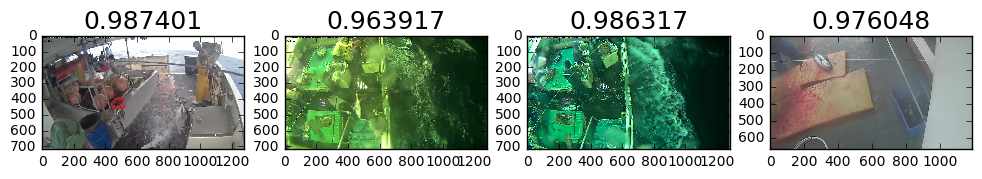

In [279]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 147 confident correct cats labels


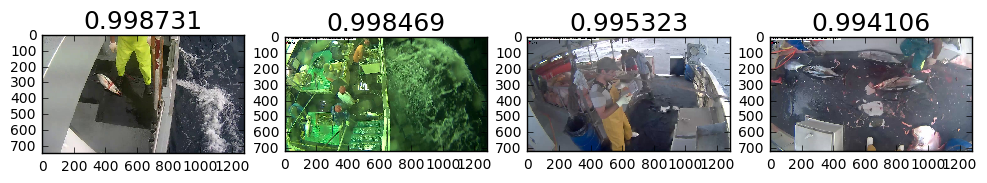

In [282]:
#3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print "Found %d confident correct cats labels" % len(correct_cats)
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

Found 4 confident correct dogs labels


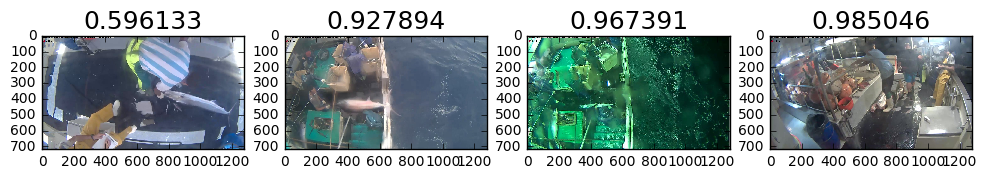

In [290]:
#3b. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((our_labels==5) & (our_labels==expected_labels))[0]
print "Found %d confident correct dogs labels" % len(correct_dogs)
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

Found 193 incorrect cats


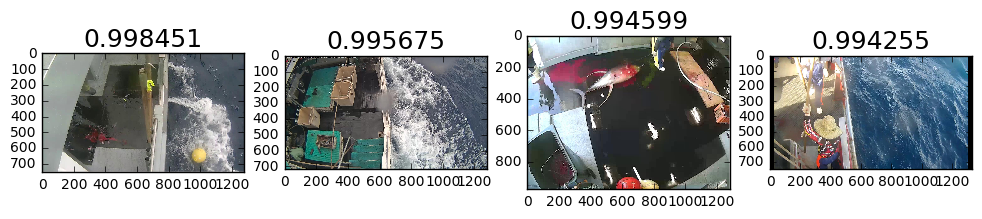

In [291]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print "Found %d incorrect cats" % len(incorrect_cats)
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

Found 36 incorrect dogs


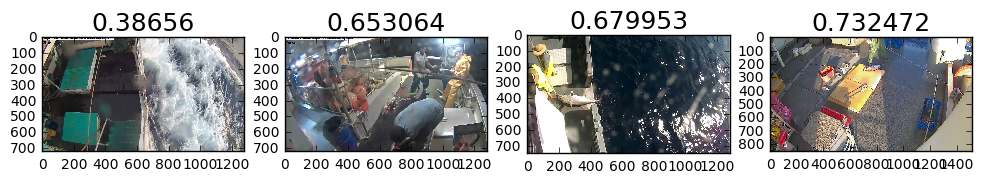

In [292]:
#4b. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print "Found %d incorrect dogs" % len(incorrect_dogs)
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

In [208]:
expected_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
